# Dask imaging demonstration

This notebook explores the use of dask for parallelisation. We work through the steps of imaging using dask, ending up with a major/minor cycle algorithm without and with selfcalibration.

The functions used are in pipelines/dask_graphs.py

In [1]:
%matplotlib inline

import os
import sys

from functools import partial
from dask import delayed
from distributed import progress

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from arl.data.data_models import Image, BlockVisibility, Visibility
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.operations import create_blockvisibility, create_visibility_from_rows, \
    copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.image.gather_scatter import image_gather, image_scatter
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.visibility.operations import qa_visibility
from arl.util.testing_support import create_named_configuration, simulate_gaintable
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, predict_timeslice, invert_timeslice, \
    predict_wstack, invert_wstack, normalize_sumwt, create_image_from_visibility, \
    invert_wprojection, predict_wprojection,\
    predict_skycomponent_blockvisibility, residual_image, invert_timeslice_single, \
    predict_timeslice_single, predict_timeslice_single, advise_wide_field
from arl.graphs.dask_init import get_dask_Client, kill_dask_Client
from arl.graphs.dask_graphs import create_invert_graph, create_deconvolve_graph, \
    create_continuum_imaging_pipeline_graph, create_ical_pipeline_graph, create_residual_graph, \
    create_deconvolve_facet_graph, create_invert_facet_graph, create_predict_facet_graph, \
    create_residual_facet_graph, create_predict_graph, create_zero_vis_graph_list, create_subtract_vis_graph_list
from arl.graphs.generic_dask_graphs import create_generic_image_graph

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
c=get_dask_Client()
print(c)
c.scheduler_info()

Creating Dask Client
<Client: scheduler='tcp://127.0.0.1:56888' processes=8 cores=8>


{'address': 'tcp://127.0.0.1:56888',
 'id': '534734ca-5bdb-11e7-82f6-dca9047aea9f',
 'services': {'bokeh': 8787},
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:56897': {'host': '127.0.0.1',
   'last-seen': 1498638323.575413,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nanny-il0o7zb9',
   'memory_limit': 1288490188.0,
   'name': 'tcp://127.0.0.1:56897',
   'ncores': 1,
   'services': {'bokeh': 56901, 'nanny': 56893},
   'time-delay': 0.0066759586334228516},
  'tcp://127.0.0.1:56898': {'host': '127.0.0.1',
   'last-seen': 1498638323.57653,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nanny-3rm138kt',
   'memory_limit': 1288490188.0,
   'name': 'tcp://127.0.0.1:56898',
   'ncores': 1,
   'services': {'bokeh': 56902, 'nanny': 56895},
   'time-delay': 0.007542133331298828},
  'tcp://127.0.0.1:56899': {'host': '127.0.0.1',
   'last-seen': 1498638323.577857,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nan

We create the visibility and fill in values with the transform of a number of point sources. 

In [3]:
def ingest_visibility(freq=1e8, chan_width=1e6, time=0.0, reffrequency=[1e8], add_errors=True):
    lowcore = create_named_configuration('LOWBD2-CORE')
    times = [time]
    frequency = numpy.array([freq])
    channel_bandwidth = numpy.array([chan_width])

    phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-26.7 * u.deg, frame='icrs', equinox=2000.0)
    vt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                weight=1.0, phasecentre=phasecentre, 
                                polarisation_frame=PolarisationFrame("stokesI"))
    npixel = 256
    cellsize=0.001
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1, frequency=reffrequency,
                                        polarisation_frame=PolarisationFrame("stokesI"))
    flux = numpy.array([[100.0]])
    facets = 4

    spacing_pixels = npixel // facets
    spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
    centers = -1.5, -0.5, +0.5, +1.5
    comps = list()
    for iy in centers:
        for ix in centers:
            pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
            pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
            sc = pixel_to_skycoord(pra, pdec, model.wcs)
            comps.append(create_skycomponent(flux=flux, frequency=vt.frequency, direction=sc, 
                                             polarisation_frame=PolarisationFrame("stokesI")))
    predict_skycomponent_blockvisibility(vt, comps)
    if add_errors:
        gt = create_gaintable_from_blockvisibility(vt)
        gt = simulate_gaintable(gt, phase_error=1.0, amplitude_error=0.0)
        vt = apply_gaintable(vt, gt)
    return vt

Get the Local Sky Model. It contains only one of the input point sources

In [4]:
def get_LSM(vt, npixel = 512, cellsize=0.001, reffrequency=[1e8]):
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1, frequency=reffrequency,
                                        polarisation_frame=PolarisationFrame("stokesI"))
    return model

In [5]:
nfreqwin=7
vis_graph_list=list()
for freq in numpy.linspace(0.8e8,1.2e8,nfreqwin):
    vis_graph_list.append(delayed(ingest_visibility)(freq, time=0.0))
    
nvis=len(vis_graph_list)

npixel=256
facets=4
model_graph = delayed(get_LSM)(vis_graph_list[nvis//2], npixel=npixel)

In [6]:
print(advise_wide_field(vis_graph_list[0].compute(), guard_band_image=0.5))

advise_wide_field: Maximum baseline 787.4 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.053534 (rad) 3.067 (deg)
advise_wide_field: Facet field of view 0.053534 (rad) 3.067 (deg)
advise_wide_field: Synthesized beam 0.001270 (rad) 0.073 (deg)
advise_wide_field: Cellsize 0.000423 (rad) 0.024 (deg)
advice_wide_field: Npixels per side = 126
advice_wide_field: W sampling for full image = 22.2 (wavelengths)
advice_wide_field: W sampling for facet = 22.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 775.9 (s)
advice_wide_field: Time sampling for facet = 775.9 (s)
advice_wide_field: Time sampling for primary beam = 194.0 (s)
advice_wide_field: Frequency sampling for full image = 718426.0 (Hz)
advice_wide_field: Frequency sampling for 

In [7]:
predict_preferred=predict_wprojection
invert_preferred=invert_wprojection

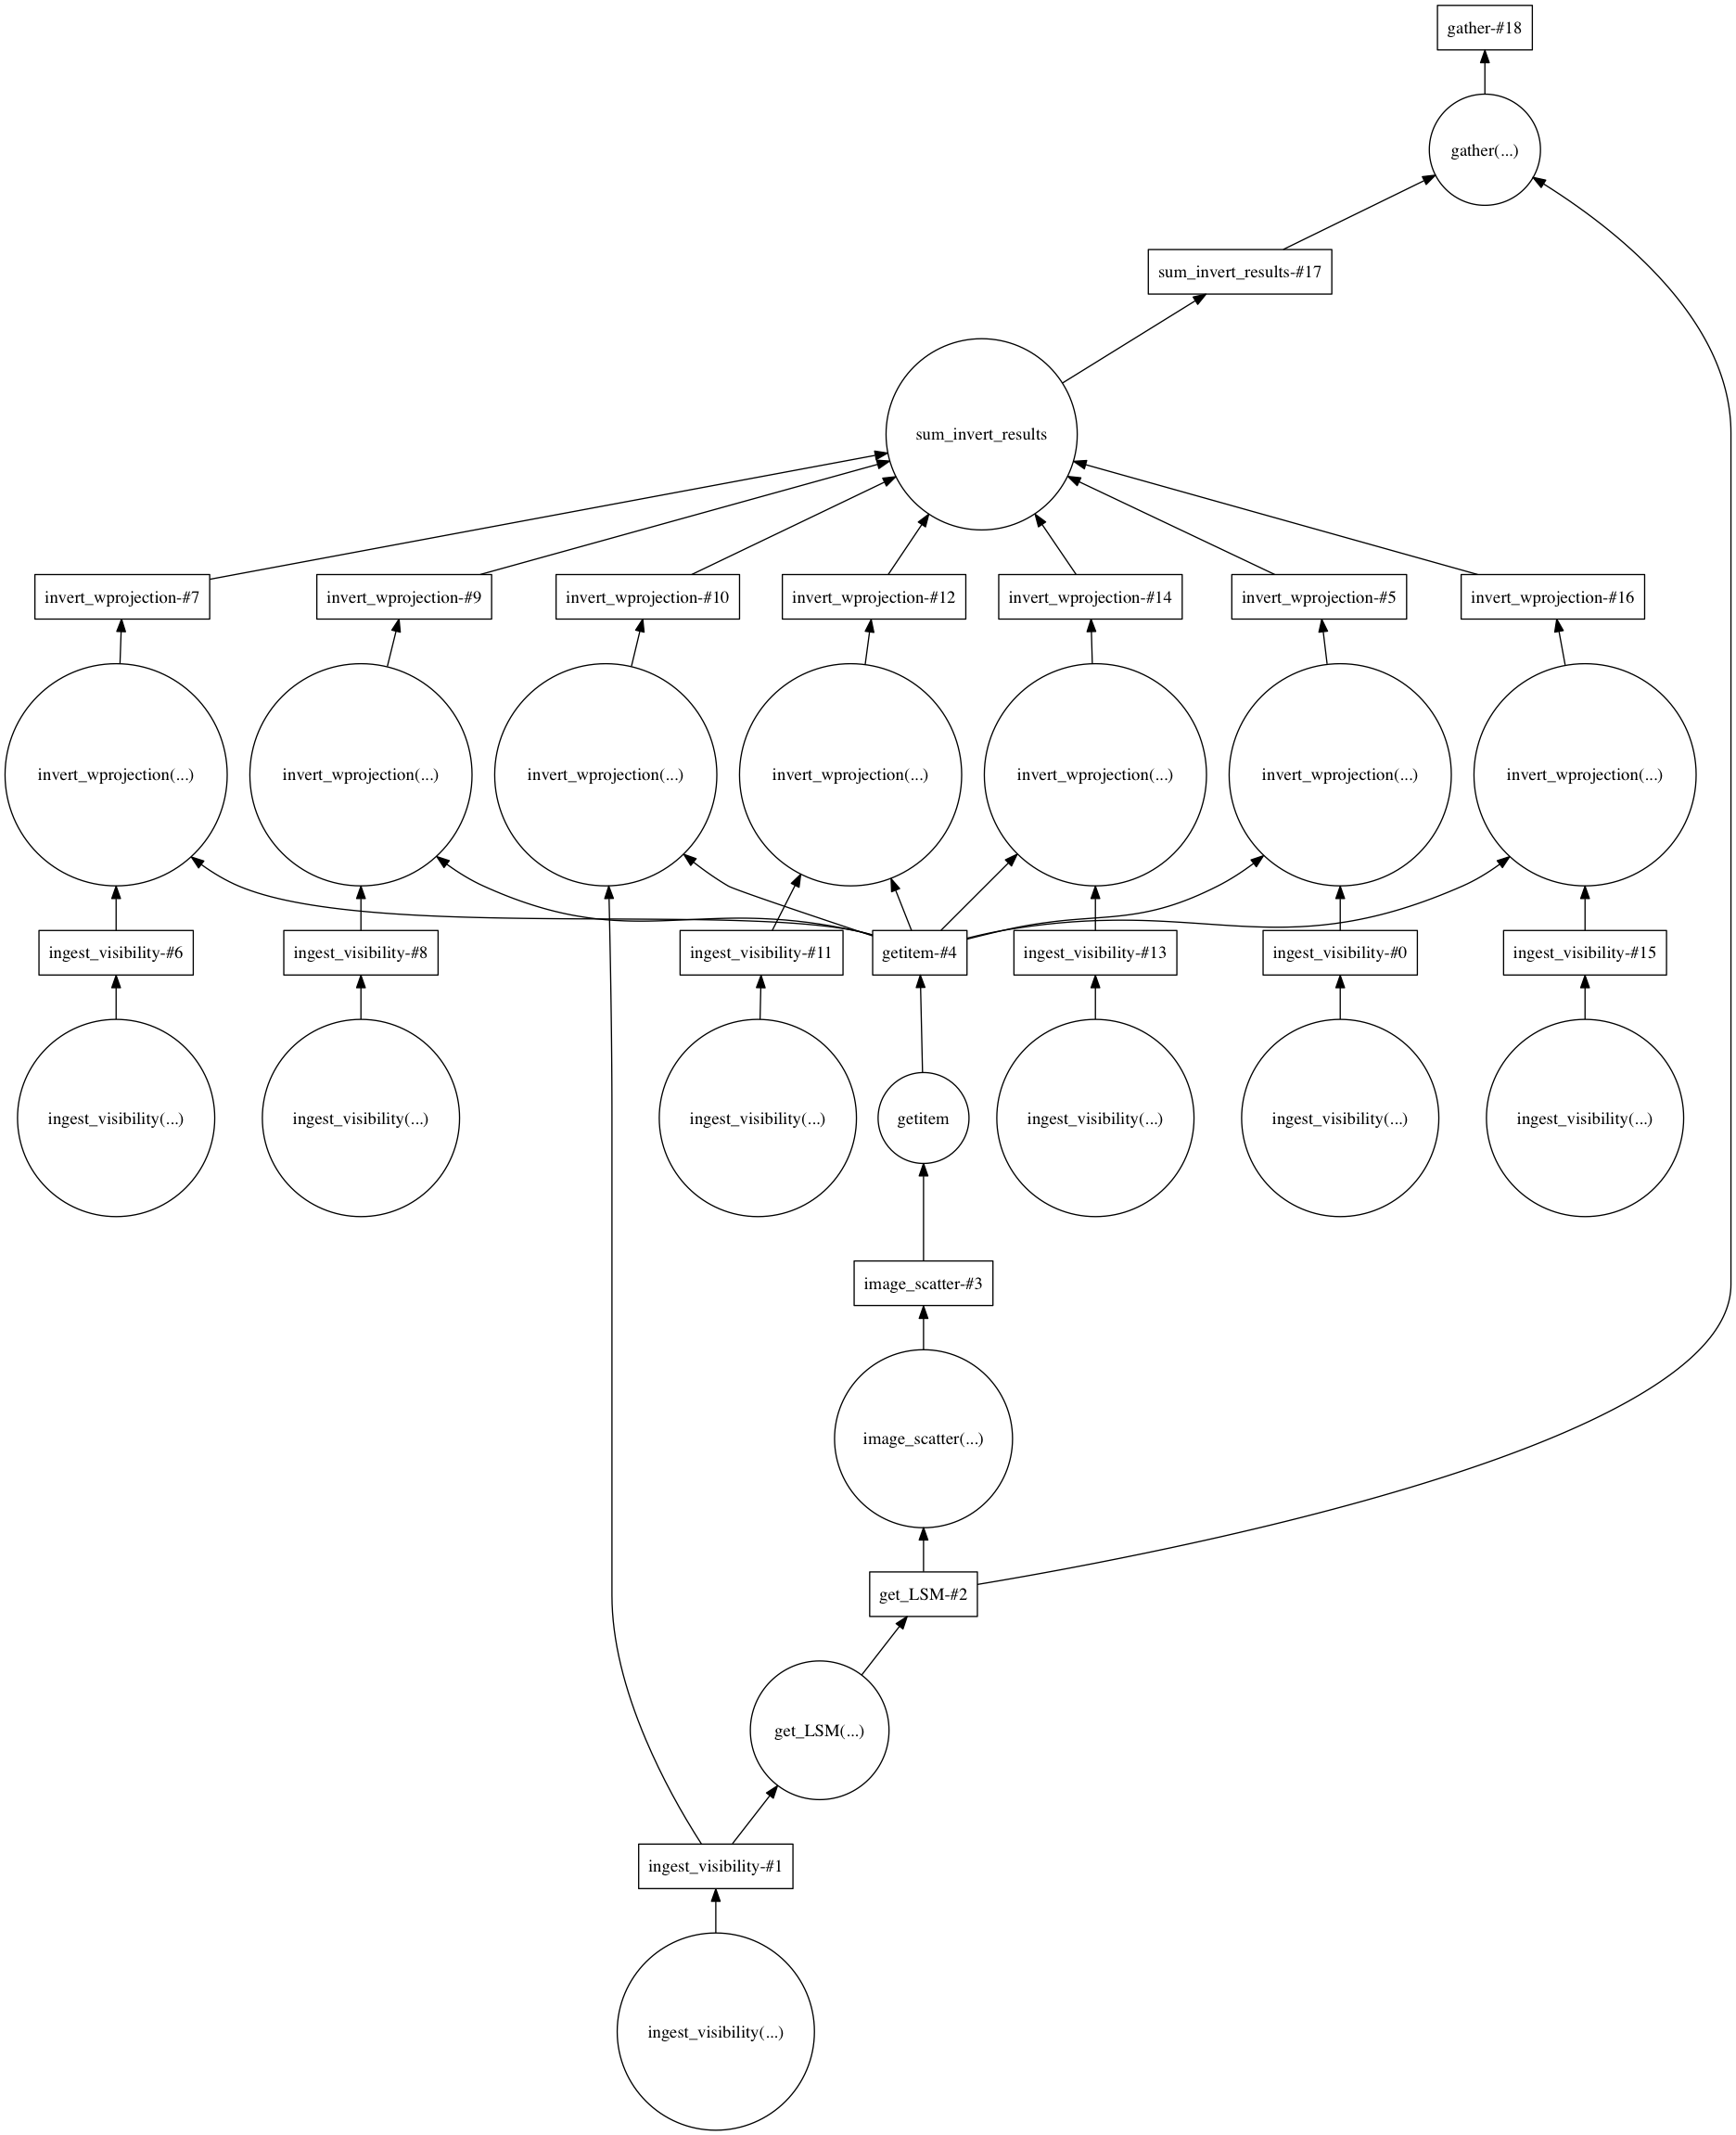

In [8]:
dirty_graph = create_invert_facet_graph(vis_graph_list, model_graph, wstep=25, wstack=25,
                                        invert_single=invert_preferred, 
                                        predict_single=predict_preferred,
                                        dopsf=False)
psf_graph = create_invert_facet_graph(vis_graph_list, model_graph, wstep=25, wstack=25,
                                      invert_single=invert_preferred, 
                                      predict_single=predict_preferred,
                                      opsf=True)
dirty_graph.visualize()

Quality assessment:
	Origin: qa_image
	Context: Dirty image
	Data:
		shape: (1, 1, 256, 256)
		max: 38.2659957411
		min: -3.2879618461
		rms: 1.99018555883
		sum: -477.799162603
		medianabs: 0.653069762222
		median: -0.185009495778



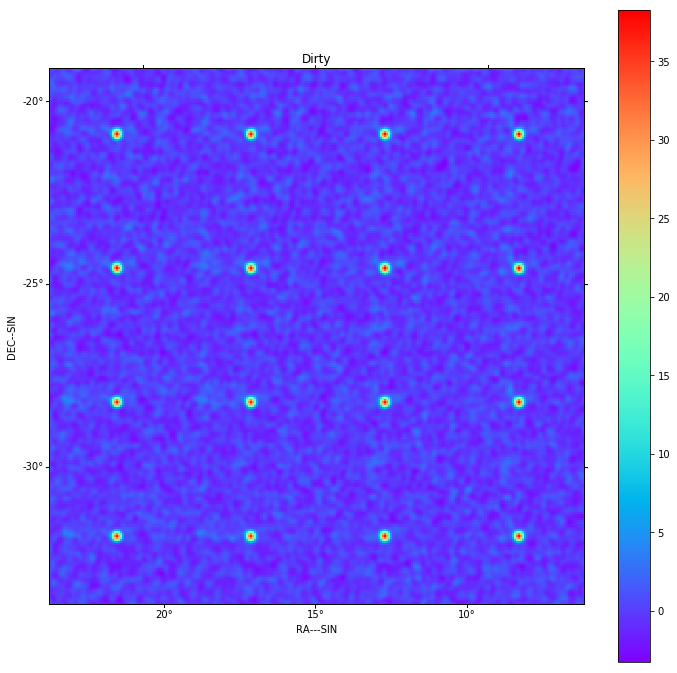

In [9]:
future=c.compute(dirty_graph)
dirty=future.result()[0]
print(qa_image(dirty, context='Dirty image'))
show_image(dirty, title='Dirty')
plt.show()

We now create a graph to perform a minor/major cycle deconvolution

In [10]:
continuum_imaging_graph = \
    create_continuum_imaging_pipeline_graph(vis_graph_list, model_graph=model_graph, 
                                            c_deconvolve_graph=create_deconvolve_facet_graph,
                                            c_invert_graph=create_invert_graph,
                                            c_residual_graph=create_residual_graph,
                                            invert_single=invert_wprojection, 
                                            predict_single=predict_wprojection,
                                            wstep=25, wstack=25,
                                            algorithm='hogbom', niter=1000, 
                                            fractional_threshold=0.1, threshold=2.0, nmajor=2,
                                            gain=0.1, facets=4)

In [11]:
future=c.compute(continuum_imaging_graph)

Quality assessment:
	Origin: qa_image
	Context: Clean image - no selfcal
	Data:
		shape: (1, 1, 256, 256)
		max: 30.4968219094
		min: -1.00126567837
		rms: 0.454980123097
		sum: 630.727779067
		medianabs: 0.0
		median: 0.0



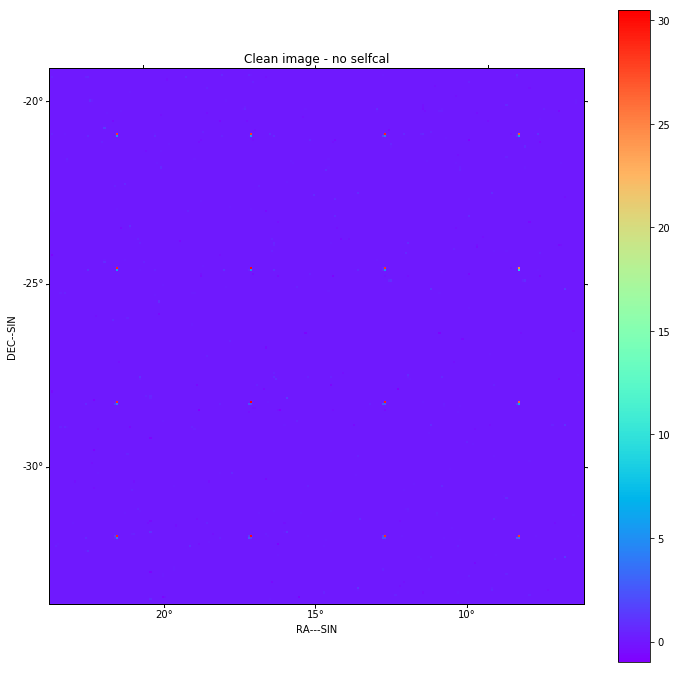

Quality assessment:
	Origin: qa_image
	Context: Restored clean image - no selfcal
	Data:
		shape: (1, 1, 256, 256)
		max: 36.3856915877
		min: -2.89440876557
		rms: 1.83024278441
		sum: 11638.8095399
		medianabs: 0.558226605838
		median: 0.0242454220253



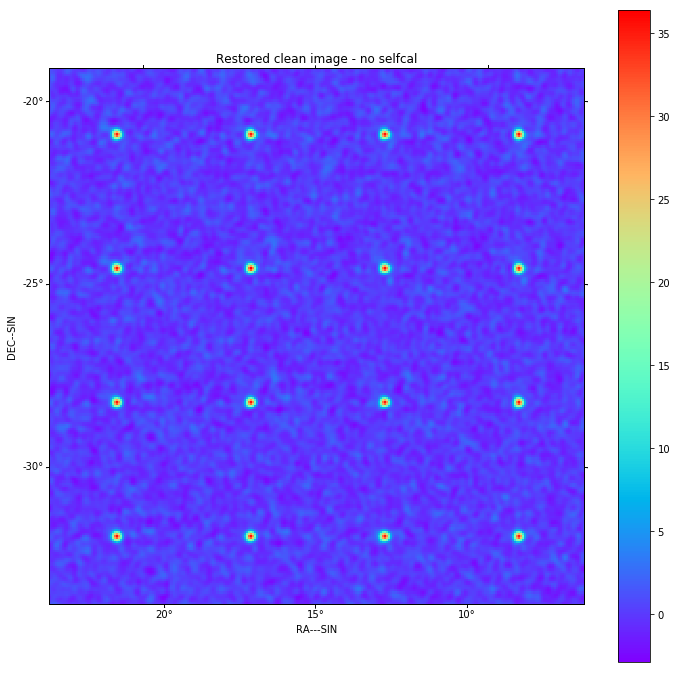

Quality assessment:
	Origin: qa_image
	Context: Residual clean image - no selfcal
	Data:
		shape: (1, 1, 256, 256)
		max: 2.0269935293
		min: -2.02041140555
		rms: 0.774022180731
		sum: 343.506223355
		medianabs: 0.538932172489
		median: -0.00785152766405



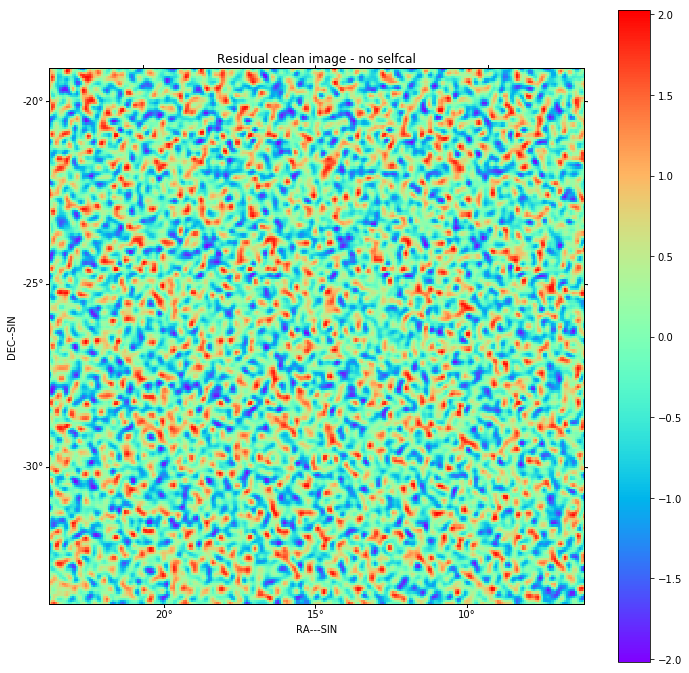

In [12]:
deconvolved = future.result()[0]
residual = future.result()[1]
restored = future.result()[2]

f=show_image(deconvolved, title='Clean image - no selfcal')
print(qa_image(deconvolved, context='Clean image - no selfcal'))
plt.show()

f=show_image(restored, title='Restored clean image - no selfcal')
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()

f=show_image(residual[0], title='Residual clean image - no selfcal')
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()

In [13]:
ical_graph = create_ical_pipeline_graph(vis_graph_list, model_graph=model_graph, algorithm='hogbom', 
                                        c_deconvolve_graph=create_deconvolve_facet_graph,
                                        c_invert_graph=create_invert_graph,
                                        c_residual_graph=create_residual_graph,
                                        invert_single=invert_wprojection, 
                                        predict_single=predict_wprojection,
                                        wstep=25, wstack=25,
                                        niter=1000, fractional_threshold=0.1,
                                        threshold=2.0, nmajor=3, first_selfcal=1, gain=0.1, facets=2)
#g=ical_graph.visualize(filename='imaging-dask-ical-graph-%d' % (nfreqwin), format='svg')

In [14]:
future=c.compute(ical_graph)

Quality assessment:
	Origin: qa_image
	Context: Clean clean image
	Data:
		shape: (1, 1, 256, 256)
		max: 93.8320976277
		min: -0.969552593292
		rms: 1.44696451159
		sum: 1666.25810083
		medianabs: 0.0
		median: 0.0



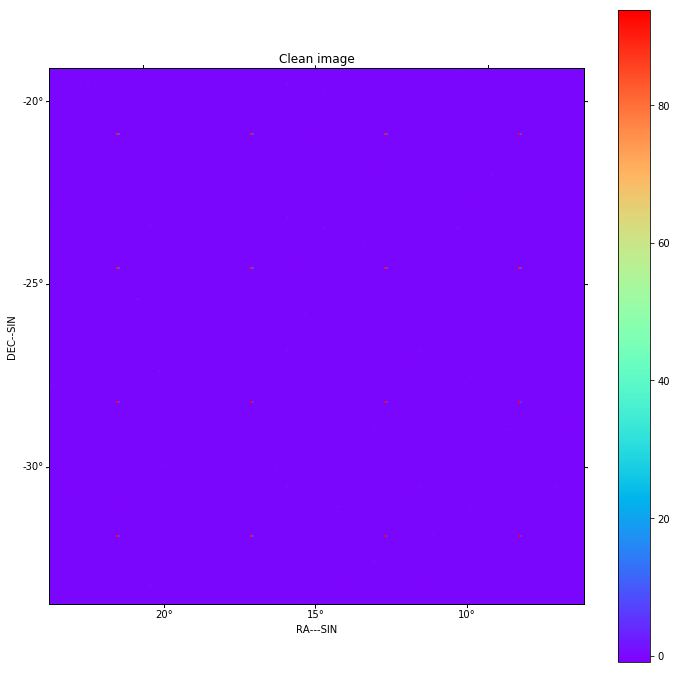

Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: (1, 1, 256, 256)
		max: 100.037863444
		min: -0.191613943961
		rms: 4.65500897238
		sum: 29847.7360927
		medianabs: 0.0394247493261
		median: 0.020508880837



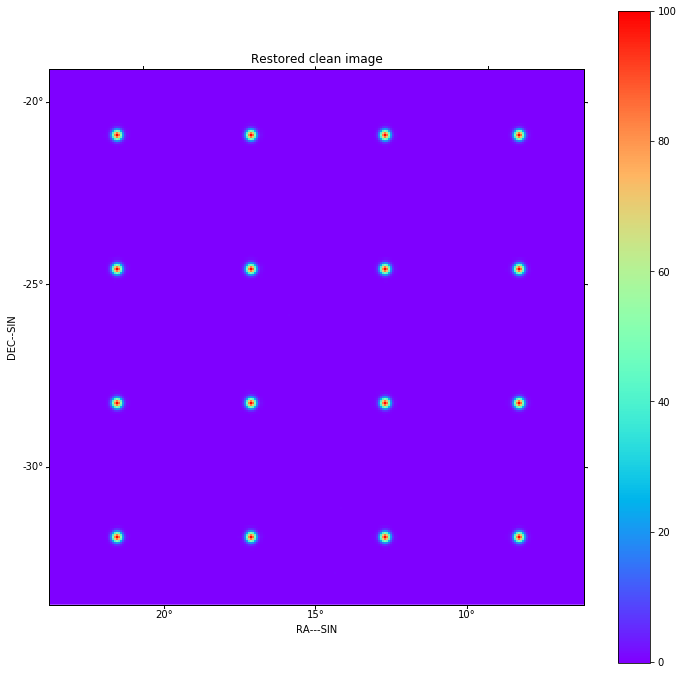

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: (1, 1, 256, 256)
		max: 2.01382168984
		min: -1.96914700874
		rms: 0.151191788105
		sum: -3.4299881783
		medianabs: 0.0439260737733
		median: 0.0105433728097



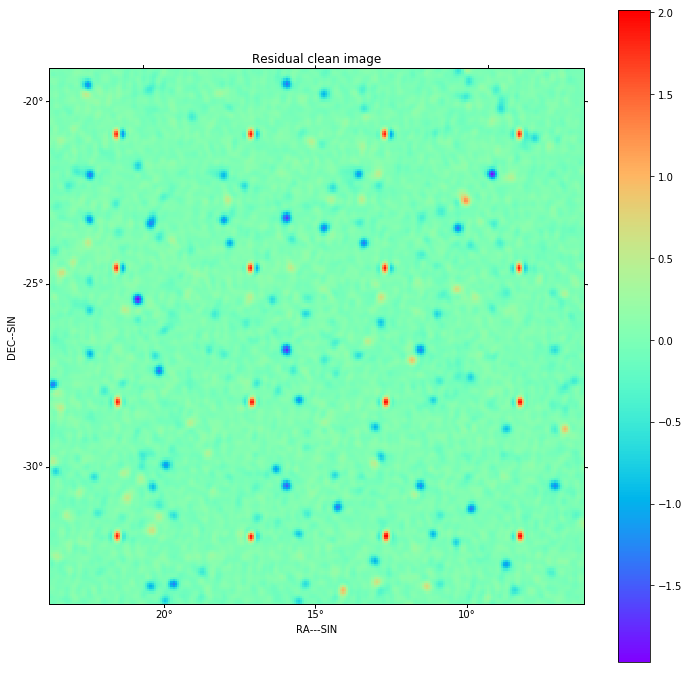

In [15]:
deconvolved = future.result()[0]
residual = future.result()[1]
restored = future.result()[2]

f=show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean clean image'))
plt.show()

f=show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()

f=show_image(residual[0], title='Residual clean image')
print(qa_image(residual[0], context='Residual clean image'))
plt.show()

In [16]:
c.shutdown()

distributed.batched - INFO - Batched Comm Closed: Stream is closed
distributed.batched - INFO - Batched Comm Closed: Stream is closed
